In [1]:
import numpy as np
from epcsaftpy import component, pcsaft
import json

solvent_name = 'water'
cation_name = 'Na+'
anion_name = 'Cl-'
path_exp = '../data_exp/density_' + solvent_name + '_' + cation_name + anion_name + '.txt'
letter_figure = "A"
skip_calculation = False # True if the calculation is already done

# PC-SAFT definition

In [2]:
solvent = component(solvent_name, pure_path = 'parameters/solvents.json')
cation = component(cation_name, pure_path = 'parameters/ions.json')
anion = component(anion_name, pure_path = 'parameters/ions.json')
mix = solvent + cation + anion
# Print pure parameters
mix.printParameters()
# Define binary interaction parameters
kijs = json.load(open('parameters/kijs.json'))
for i in range(mix.nc):
    for j in range(mix.nc):
        key = mix.names[i] + "_" + mix.names[j]
        try:
            kij = kijs[key]
            if type(kij)==list:
                mix.set_kijsaft(i, j, kij0=kij[0], kij1=kij[1])
            else:
                mix.set_kijsaft(i, j, kij0=kij)
        except:
            pass
# Print mixture parameters
print('\n Binary interaction parameters: kijT = kij0 + kij1*T\n')
print(mix.names)
print("kij0")
print(mix.KIJ0saft)
print("kij1")
print(mix.KIJ1saft)
# Define saft
saft = pcsaft(mix)


component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,$z$,$\epsilon_r(T)$,reference
water,18.015280,1.204682,$\sigma(T)$,353.9449,"[0, 1, 1]",2425.6714,0.04509,0.0,677.48 + 0T + -105.2ln T,solvents.json
Na+,22.989769,1.000000,2.8232,230.0000,"[0, 0, 0]",0.0000,0.00000,1.0,8.0 + 0.0T + 0.0ln T,ions.json
Cl-,35.450000,1.000000,2.756,170.0000,"[0, 0, 0]",0.0000,0.00000,-1.0,8.0 + 0.0T + 0.0ln T,ions.json



 Binary interaction parameters: kijT = kij0 + kij1*T

['water', 'Na+', 'Cl-']
kij0
[[ 0.     2.38  -0.25 ]
 [ 2.38   0.     0.317]
 [-0.25   0.317  0.   ]]
kij1
[[ 0.       -0.007981  0.      ]
 [-0.007981  0.        0.      ]
 [ 0.        0.        0.      ]]


# Read experimental data

In [3]:
# Read the experimental data from a .txt file
m_exp, T_exp, rho_exp = np.loadtxt(path_exp, unpack=True)
T_list = np.unique(T_exp)
n_T = len(T_list)
m_list = np.unique(m_exp)
n_m = len(m_list)

# Density calculation at 1 bar

In [4]:
P = 1.01325e5                               # Pa

if not skip_calculation:
    m0 = 0 # mol_sal/kg_solvent
    mf = 6
    n = 100
    m = np.linspace(m0, mf, n)
    rho = np.zeros((n_T, n))
    for j in range(n_T):
        for i in range(n):
            x = np.array([1e3/saft.Mw_solv[0], m[i], m[i]]) # This conversion is valid for one solvent ...
            x /= np.sum(x)                                  # ... and iones with the same stecchiometry
            rhocal = saft.density(x, T_list[j], P, "L")
            rho[j, i] = np.dot(x, saft.Mw) * rhocal * 1e-6

    # Save the results
    np.savetxt('outputs/density_vs_T_' + solvent_name + '_' + cation_name + anion_name + '.txt', np.vstack((m, rho)).T, header='m (mol/kg), rho (kg/m3)')
else:
    data_saft = np.loadtxt('outputs/density_vs_T_' + solvent_name + '_' + cation_name + anion_name + '.txt', unpack=True)
    m = data_saft[0]
    rho = data_saft[1:]

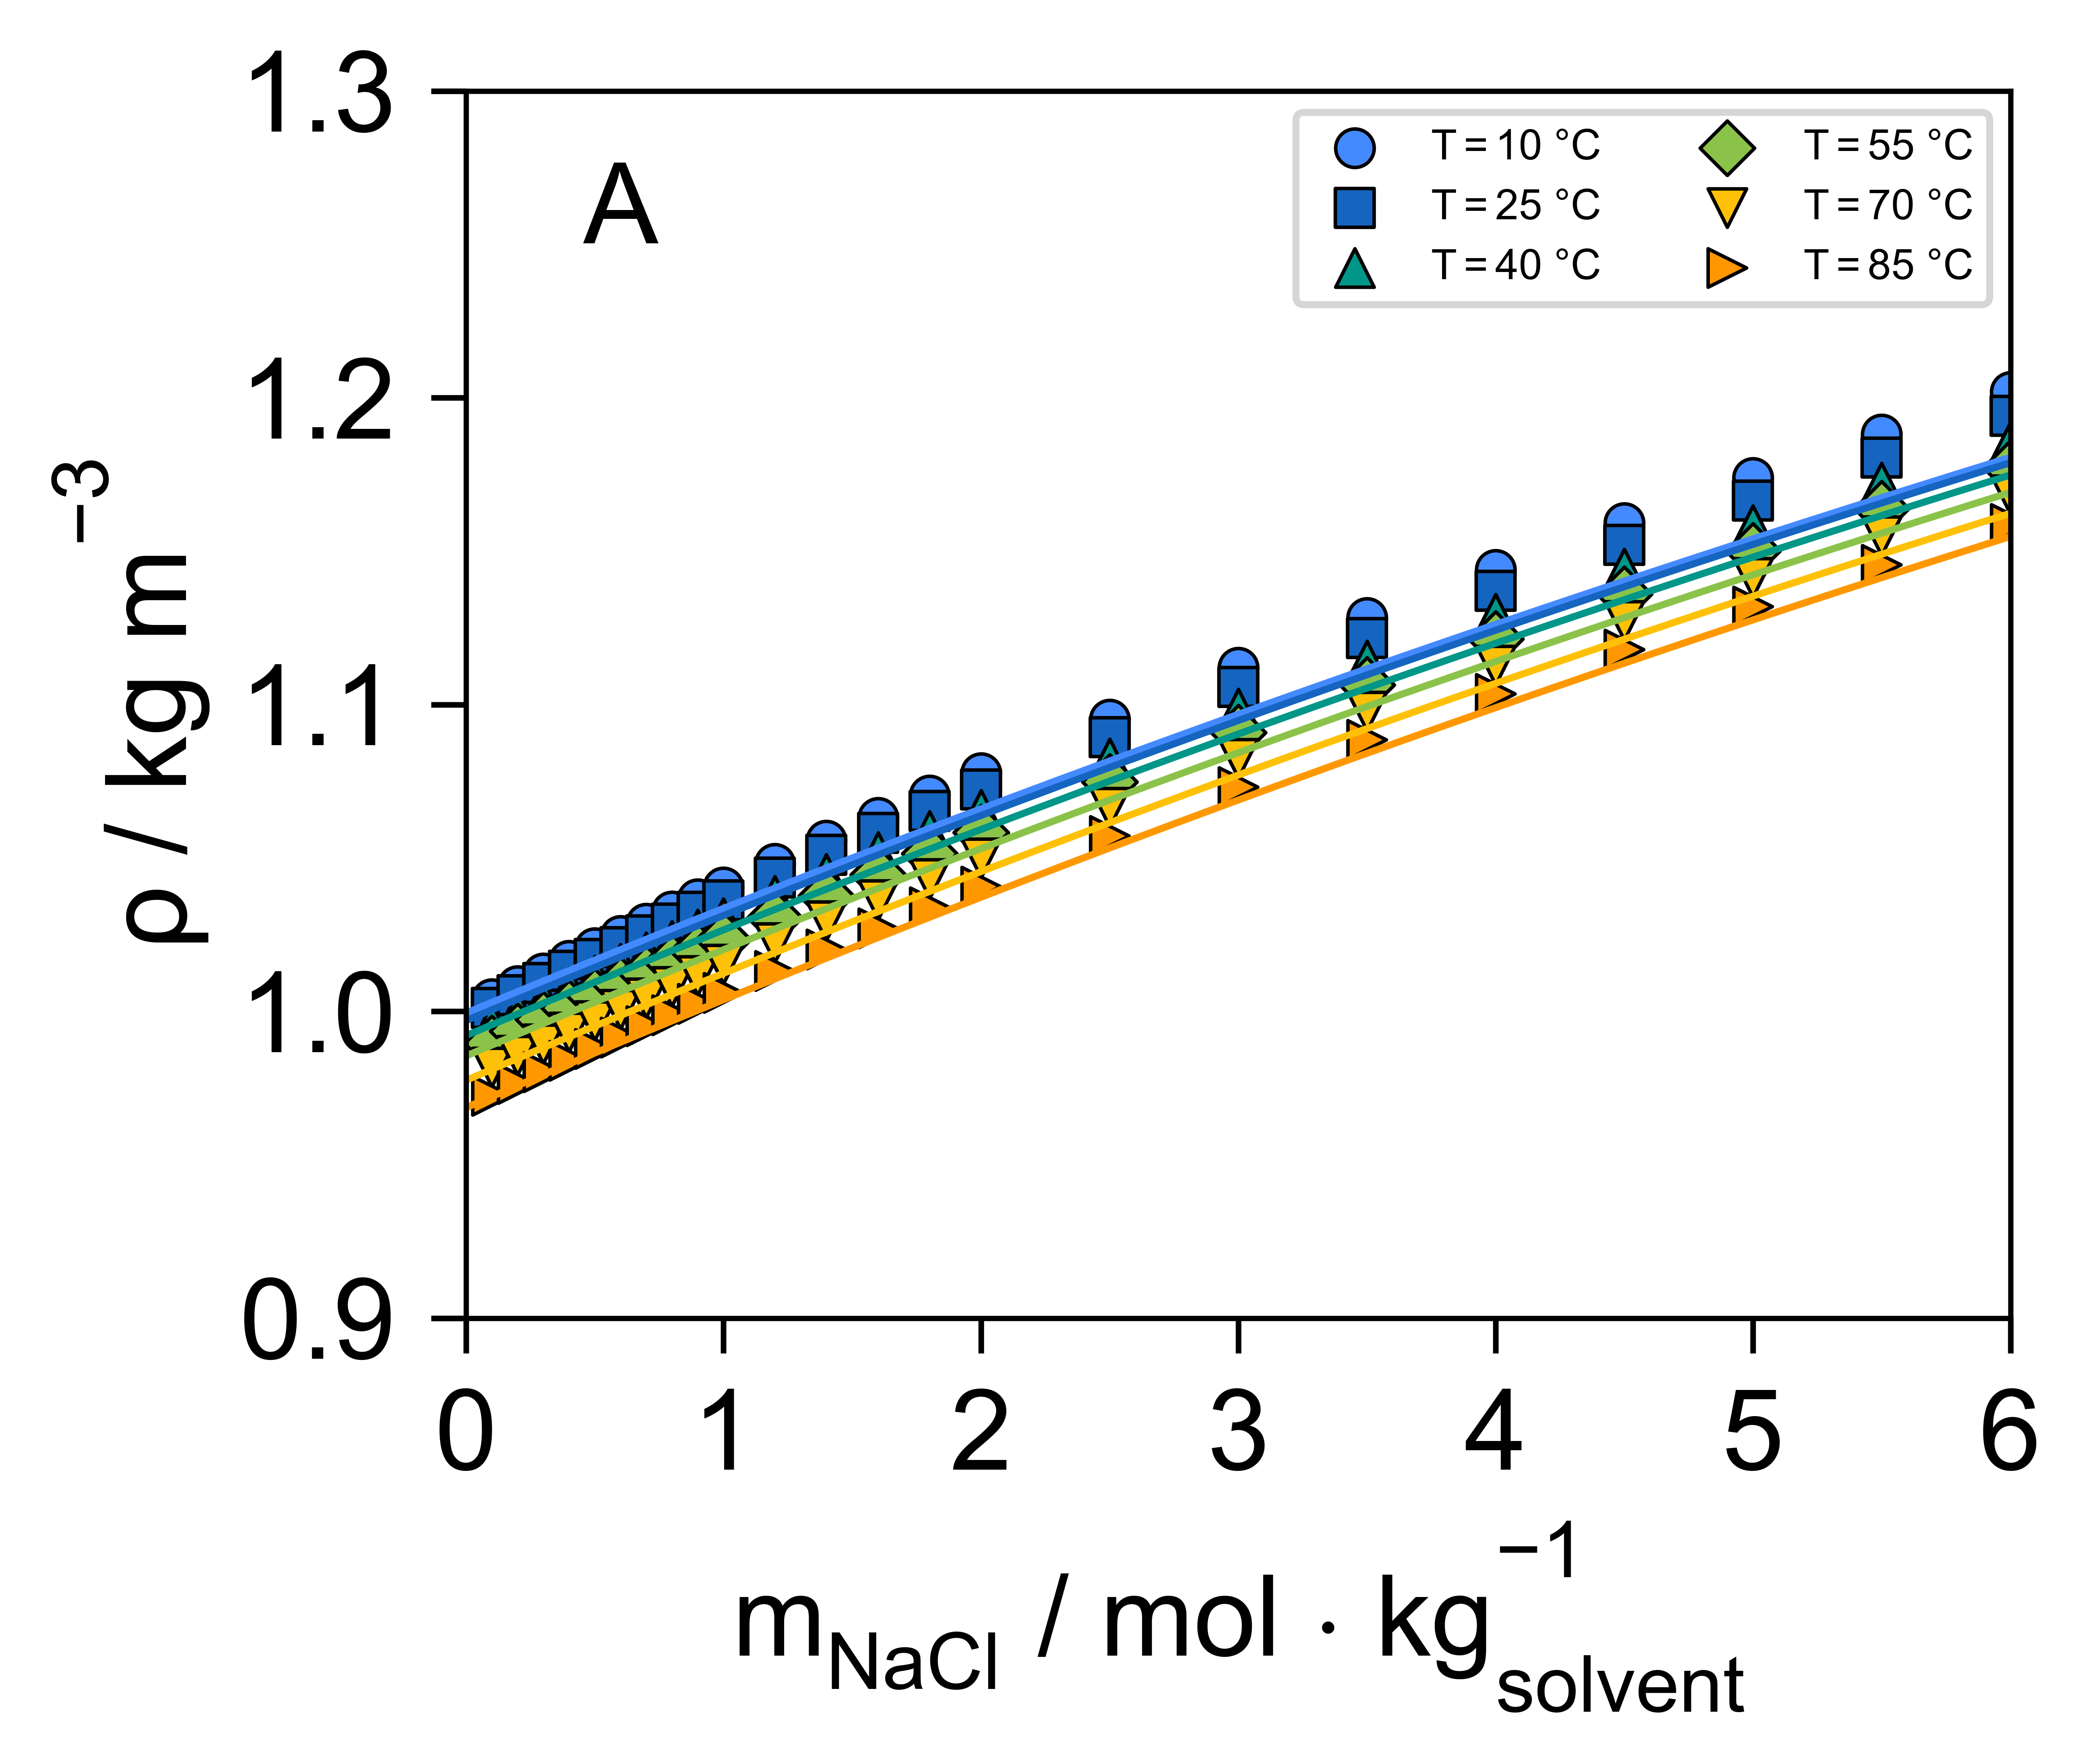

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'arial'
matplotlib.rcParams['mathtext.it'] = 'arial'
matplotlib.rcParams['mathtext.bf'] = 'arial'
matplotlib.rcParams['xtick.major.pad']='5'
matplotlib.rcParams['ytick.major.pad']='5'
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['savefig.dpi'] = 1200

font = {'weight' : 'normal',
        'size'   : 16,
        'family' : "arial"}
plt.rc('font', **font)
plt.rc('axes', titlesize=font["size"])
 
colors = ['#448AFF', '#1565C0', '#009688', '#8BC34A', '#FFC107', '#FF9800', '#F44336', '#AD1457', '#607D8B', '#000000', '#9E9E9E', '#FF5722', '#FFEB3B', '#CDDC39', '#4CAF50', '#03A9F4', '#2196F3', '#3F51B5', '#673AB7', '#9C27B0', '#E91E63', '#FF4081', '#C51162']
symbols = ['o', 's', '^', 'D', 'v', '>', '<', 'p']
symbols += symbols


fig, ax = plt.subplots(figsize=(3.93701, 3.1496), dpi = 1200)

for i in range(n_T):
    ax.plot(m, rho[i], color = colors[i], linewidth = 1.)
    index = np.where(T_exp == T_list[i])
    ax.scatter(m_exp[index], rho_exp[index], 
               color = colors[i], marker = symbols[i], linewidth=0.5, edgecolor='k', label = f'$T = {T_list[i] - 273.15:.0f}$ °C', s = 30)

ax.text(0.1, 0.9, letter_figure, horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize = 16)    

# Axis label names
ax.set_xlabel(r'$m_{\mathrm{NaCl}}$ / mol $\cdot$ kg$_{\mathrm{solvent}}^{-1}$')
ax.set_ylabel(r'$\rho$ / kg m$^{-3}$')

# Axis label formatting
ax.set_xlim(0, 6)
ax.set_ylim(0.9, 1.3)
ax.xaxis.set_ticks(np.linspace(0, 6, 7))
ax.yaxis.set_ticks(np.linspace(0.9, 1.3, 5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)
ax.legend(fontsize=6, ncol=2, loc='upper right')
plt.savefig('../figures/density_vs_T_' + solvent_name + '_' + cation_name + anion_name + '.pdf', bbox_inches='tight')
plt.show()


In [6]:
P = 1.01325e5                               # Pa

if not skip_calculation:
    m0 = 0 # mol_AnxCaty/kg_solvent
    mf = 6
    n = 100
    T = np.linspace(280, 380, n)
    rho = np.zeros((n_m, n))
    for j in range(n_m):
        for i in range(n):
            x = np.array([1e3/saft.Mw_solv[0], m_list[j], m_list[j]])
            x /= np.sum(x)
            rhocal = saft.density(x, T[i], P, "L")
            rho[j, i] = np.dot(x, saft.Mw) * rhocal * 1e-6
    
    # Save the results
    np.savetxt('outputs/density_vs_m_' + solvent_name + '_' + cation_name + anion_name + '.txt', np.vstack((T, rho)).T, header='T (K), rho (kg/m3)')
else:
    data_saft = np.loadtxt('outputs/density_vs_m_' + solvent_name + '_' + cation_name + anion_name + '.txt', unpack=True)
    T = data_saft[0]
    rho = data_saft[1:]
    

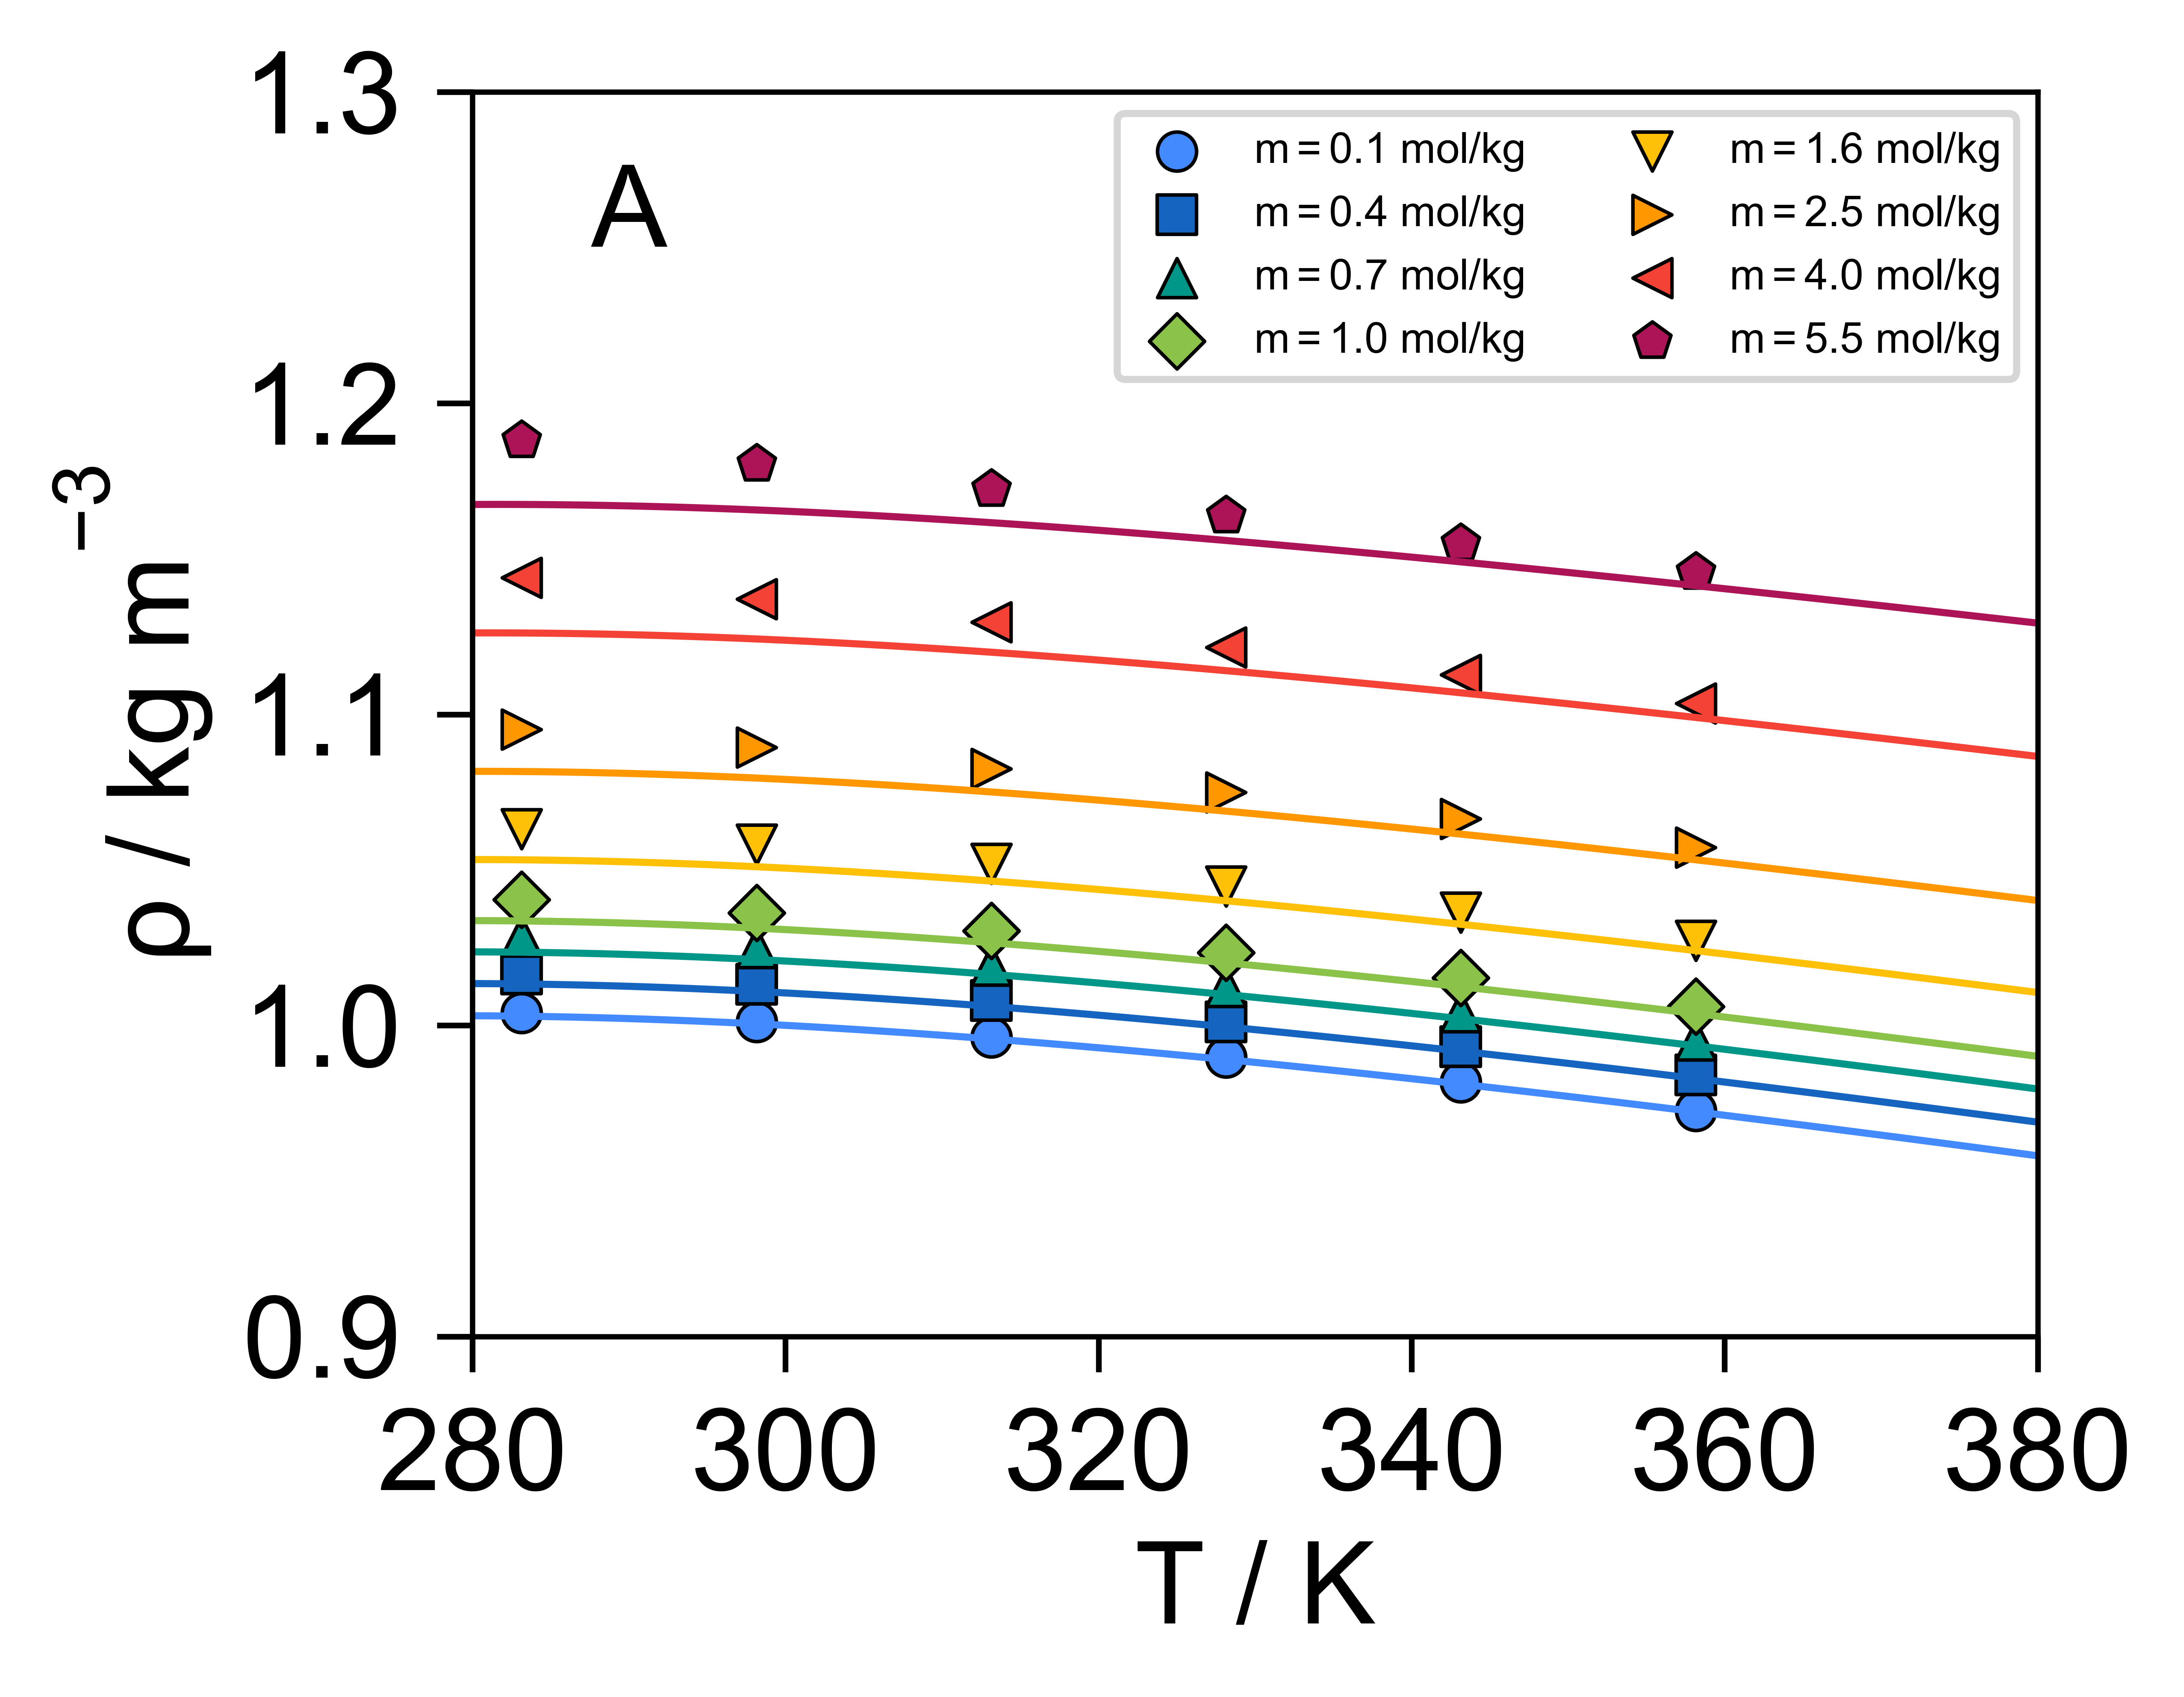

In [7]:
fig, ax = plt.subplots(figsize=(3.93701, 3.1496), dpi = 1200)
j=-1
for i in range(0,n_m,3):
    j+=1
    ax.plot(T, rho[i], color = colors[j], linewidth = 1.)
    index = np.where(m_exp == m_list[i])
    ax.scatter(T_exp[index], rho_exp[index], 
               color = colors[j], marker = symbols[j], linewidth=0.5, edgecolor='k', label = f'$m = {m_list[i]:.1f}$ mol/kg', s = 30)

ax.text(0.1, 0.9, letter_figure, horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, fontsize = 16)

# Axis label names
ax.set_xlabel(r'$T$ / K')
ax.set_ylabel(r'$\rho$ / kg m$^{-3}$')

# Axis label formatting
ax.set_xlim(280, 380)
ax.set_ylim(0.9, 1.3)
ax.xaxis.set_ticks(np.linspace(280, 380, 6))
ax.yaxis.set_ticks(np.linspace(0.9, 1.3, 5))
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', length=3)
ax.legend(fontsize=6, ncol=2, loc='upper right')
plt.savefig('../figures/density_vs_m_' + solvent_name + '_' + cation_name + anion_name + '.pdf', bbox_inches='tight')
plt.show()

# The Gibbs energy of solvation
 Compared with Figure 2 from Fluid Phase Equilibria 535 (2021) 112967.

In [8]:
T = 298.15
P = 1.01325e5                               # Pa
xzero = 1e-10
x = np.array([1 - 2*xzero, xzero, xzero])
lnphi, _ = saft.logfugef(x, T, P, "L")
R = 8.31446261815324                        # J/(mol K)

dG_cation = R*T*lnphi[1] * 1e-3
dG_anion = R*T*lnphi[2] * 1e-3
print(f'dG_cation = {dG_cation:.2f} kJ/mol')
print(f'dG_anion = {dG_anion:.2f} kJ/mol')

dG_cation = -541.88 kJ/mol
dG_anion = -557.48 kJ/mol
